In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [25]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
from IPython.display import Image
tf.__version__

'2.1.0'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
%matplotlib inline

# Object detection

- see the original papers on [Yolov3](https://pjreddie.com/media/files/papers/YOLOv3.pdf),  [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf)



### Approaches:

- **Classical**: Sliding window, costly
- **Two Stage Detectors**: First obtain proposed regions, then classify.
- **One Stage Detectors**: Use region priors on fixed image grid

# Observe how an image is annotated for detection

This is an example from the [Open Images V6 Dataset](https://storage.googleapis.com/openimages/web/index.html), a dataset created and curated at Google. Explore and inspect images and annotations to understand the dataset.

Particularly:

- get a view on the volumetry and class descriptions in https://storage.googleapis.com/openimages/web/factsfigures.html
- understand the image annotation formats in https://storage.googleapis.com/openimages/web/download.html

**We download the class descriptions**

In [3]:
!wget -nc https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv
c = pd.read_csv("class-descriptions-boxable.csv", names=["code", "description"], index_col="code")
c.head()

File ‘class-descriptions-boxable.csv’ already there; not retrieving.



,description
code,
/m/011k07,Tortoise
/m/011q46kg,Container
/m/012074,Magpie
/m/0120dh,Sea turtle
/m/01226z,Football


**An example image**

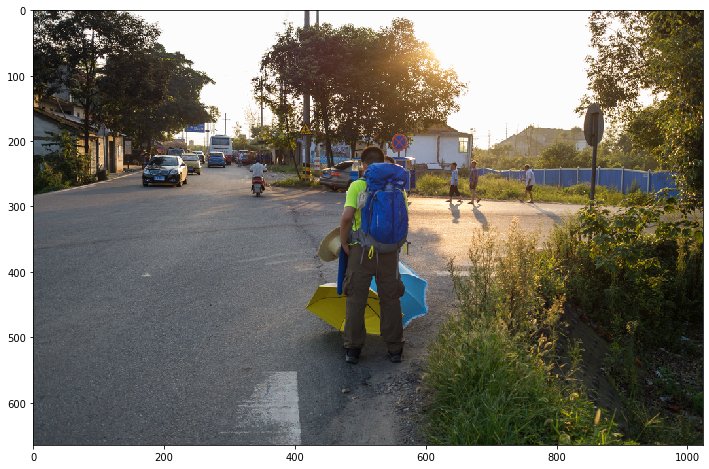

In [4]:
img = io.imread("local/data/0003bb040a62c86f.jpg")
plt.figure(figsize=(12,10))
plt.imshow(img)

**with its annotations**

In [5]:
boxes = pd.read_csv("local/data/openimages_boxes_0003bb040a62c86f.csv")
boxes

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0003bb040a62c86f,activemil,/m/07j7r,1,0.280625,0.658125,0.021174,0.347449,1,1,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,0003bb040a62c86f,xclick,/m/01g317,1,0.326250,0.349375,0.346487,0.397498,0,0,...,0,0,0.336875,0.326250,0.349375,0.344375,0.346487,0.363811,0.363811,0.397498
2,0003bb040a62c86f,xclick,/m/01g317,1,0.461875,0.553750,0.312801,0.811357,1,0,...,0,0,0.505000,0.461875,0.543750,0.553750,0.312801,0.762271,0.811357,0.760346
3,0003bb040a62c86f,xclick,/m/01g317,1,0.620000,0.641875,0.350337,0.448508,0,0,...,0,0,0.630000,0.620000,0.641875,0.621250,0.350337,0.436959,0.436959,0.448508
4,0003bb040a62c86f,xclick,/m/01g317,1,0.650625,0.671250,0.344562,0.446583,0,0,...,0,0,0.660625,0.650625,0.671250,0.668750,0.344562,0.446583,0.435034,0.442733
5,0003bb040a62c86f,xclick,/m/01g317,1,0.726250,0.754375,0.354187,0.448508,0,0,...,0,0,0.733750,0.726250,0.741250,0.754375,0.354187,0.433109,0.448508,0.401347
6,0003bb040a62c86f,xclick,/m/01mqdt,1,0.397500,0.416875,0.256978,0.286814,0,0,...,0,0,0.397500,0.406250,0.416875,0.416875,0.281039,0.256978,0.286814,0.286814
7,0003bb040a62c86f,xclick,/m/01mqdt,1,0.533125,0.560000,0.281039,0.328200,0,0,...,0,0,0.533125,0.545000,0.560000,0.546250,0.308951,0.281039,0.305101,0.328200
8,0003bb040a62c86f,xclick,/m/01prls,1,0.163750,0.233125,0.325313,0.409047,0,0,...,0,0,0.203750,0.163750,0.218125,0.233125,0.325313,0.379211,0.409047,0.366699
9,0003bb040a62c86f,xclick,/m/01prls,1,0.201875,0.227500,0.316651,0.342637,1,0,...,0,0,0.205625,0.201875,0.218125,0.227500,0.316651,0.332050,0.342637,0.324350


**the annotations of this image**


In [6]:
pd.Series([c.loc[i].description for i in boxes.LabelName]).value_counts()


Land vehicle    10
Tree             5
Person           5
Traffic sign     2
Umbrella         2
dtype: int64

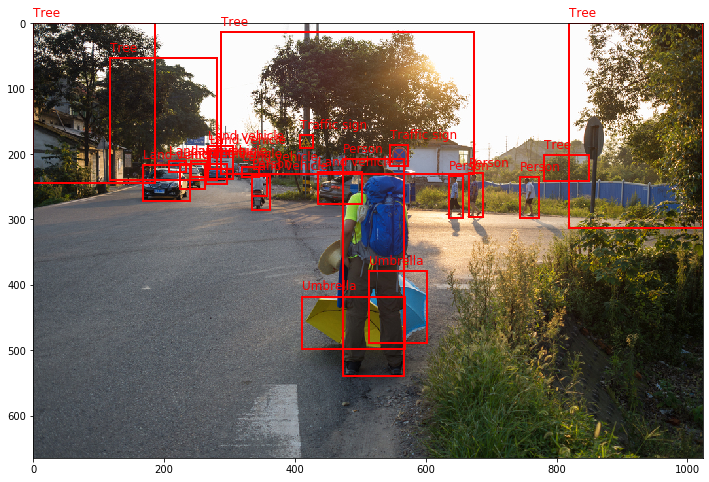

In [7]:
from matplotlib.patches import Rectangle
i = np.random.randint(len(boxes))
plt.figure(figsize=(12,10)); 
ax = plt.subplot(111)
plt.imshow(img)
h,w = img.shape[:2]
for i in range(len(boxes)):
    k = boxes.iloc[i]
    label = c.loc[k.LabelName].values[0]
    ax.add_patch(Rectangle((k.XMin*w,k.YMin*h),(k.XMax-k.XMin)*w,(k.YMax-k.YMin)*h, linewidth=2,edgecolor='r',facecolor='none'))
    plt.text(k.XMin*w, k.YMin*h-10, label, fontsize=12, color="red")

# Patch classification, with InceptionV3 from Keras

some sample patches

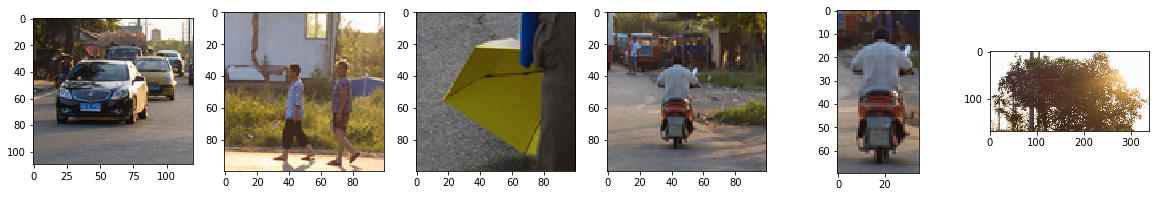

In [130]:
patches = [img[190:300, 150:270], 
           img[200:300, 600:700], 
           img[400:500, 400:500],
           img[200:300, 300:400],
           img[220:290, 325:360],
           img[10:180, 330:670]]

plt.figure(figsize=(20,3))
for i,pimg in enumerate(patches):
    plt.subplot(1,len(patches),i+1); plt.imshow(pimg)

In [131]:
from tensorflow.keras.applications import inception_v3
if not "model" in locals():
    model = inception_v3.InceptionV3(weights='imagenet', include_top=True)


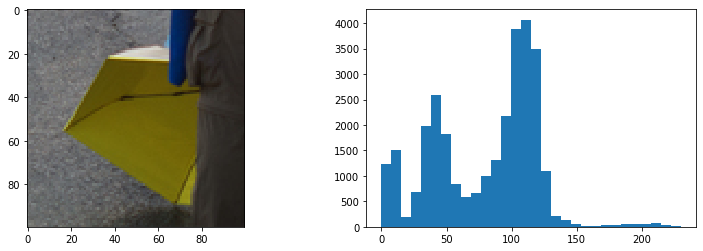

In [144]:
def plot_img_with_histogram(img):
    plt.figure(figsize=(13,4))
    plt.subplot(121)
    plt.imshow(img, vmin=np.min(img), vmax=np.max(img))
    plt.subplot(122)
    plt.hist(img.flatten(), bins=30);

pimg = patches[2]

plot_img_with_histogram(pimg)

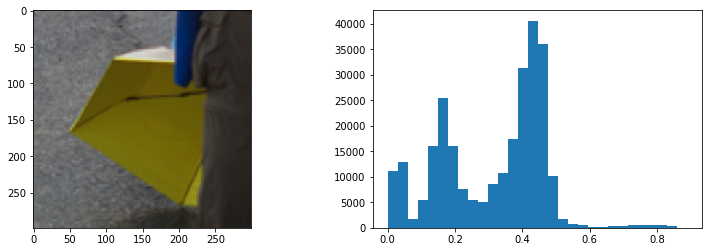

In [145]:
from skimage.transform import resize
rimg = resize(pimg, output_shape=(299,299,3))
plot_img_with_histogram(rimg)

In [146]:
pred = model.predict(rimg.reshape(-1,*rimg.shape))
pred.shape

(1, 1000)

In [147]:
k = pd.DataFrame(inception_v3.decode_predictions(pred, top=100)[0], columns=["code", "label", "preds"])
k = k.sort_values(by="preds", ascending=False)


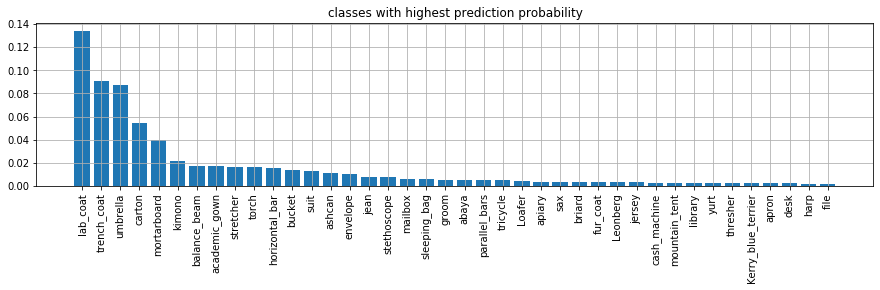

In [148]:
plt.figure(figsize=(15,3))
n = 40
plt.bar(range(n), k[:n].preds.values)
plt.xticks(range(n), k[:n].label.values, rotation="vertical");
plt.title("classes with highest prediction probability")
plt.grid();

observe how we decode prediction classes. We would nee to **align** them with our detectiond dataset.

In [149]:
print ('Predicted:')
k = inception_v3.decode_predictions(pred, top=10)[0]
for i in k:
    print("%10s %20s %.6f"%i)

Predicted:
 n03630383             lab_coat 0.134186
 n04479046          trench_coat 0.090892
 n04507155             umbrella 0.087079
 n02971356               carton 0.054701
 n03787032          mortarboard 0.039948
 n03617480               kimono 0.021387
 n02777292         balance_beam 0.017429
 n02669723        academic_gown 0.016952
 n04336792            stretcher 0.016528
 n04456115                torch 0.016192


# Patch classification, with ResNet model published on [TensorFlow Hub](https://www.tensorflow.org/hub)

In [150]:
import tensorflow_hub as hub

In [151]:
classnames = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt', names=["label"])
if not 'm' in locals():
    m = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4")
    ])
    m.build([None, 299, 299, 3])  

In [152]:
m.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  55875273  
Total params: 55,875,273
Trainable params: 0
Non-trainable params: 55,875,273
_________________________________________________________________


In [153]:
preds = m(rimg.reshape(-1,*rimg.shape).astype(np.float32)).numpy()[0]
preds = np.exp(preds)/np.sum(np.exp(preds))
np.sum(preds)

0.99999994

In [154]:
names = classnames.copy()
names["preds"] = preds
names = names.sort_values(by="preds", ascending=False)
names.head()

,label,preds
880,umbrella,0.581176
479,carton,0.035877
870,trench coat,0.031472
835,suit,0.010810
631,Loafer,0.005403


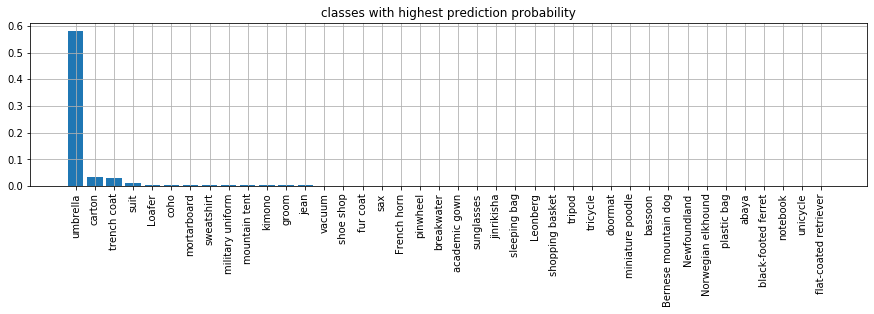

In [155]:
plt.figure(figsize=(15,3))
n = 40
plt.bar(range(n), names[:n].preds.values)
plt.xticks(range(n), names[:n].label.values, rotation="vertical");
plt.title("classes with highest prediction probability")
plt.grid();

# One stage detectors

This blog: [YOLO v3 theory explained](https://medium.com/analytics-vidhya/yolo-v3-theory-explained-33100f6d193) contains a detailed explanation on how YOLOv3 builds a prediction for detections.

## Region priors

A set of box shapes representative of what appears in the training dataset. Obtained typically with KMeans, one must decide how many. For instance

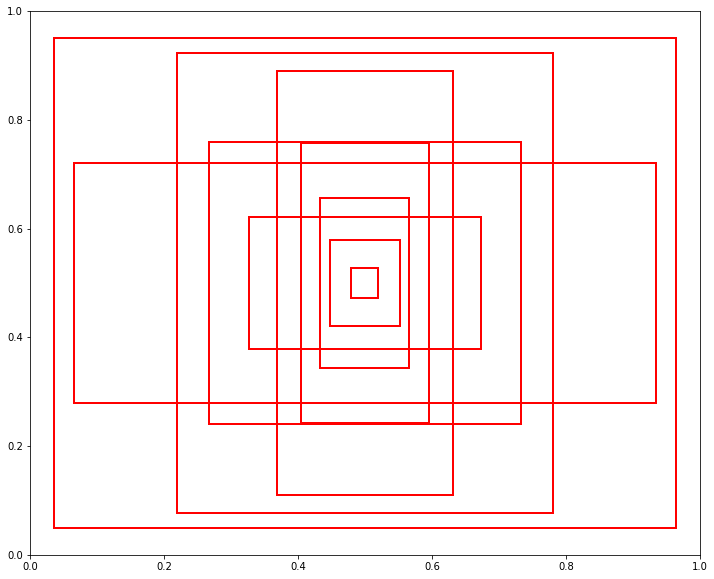

In [288]:
Image("local/imgs/anchor_boxes.png", width=300)

**Image fixed partition**

- each fixed size image cell is responsible for predicting objects whose center falls within that cell.
- for instance the red dot below signals the tree center and thus the cell responsible for its prediction.

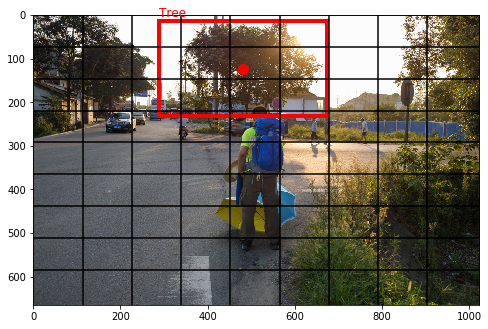

In [320]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.imshow(img)
n = 9
for i in range(n):
    plt.axvline(img.shape[1]//n*i, color="black")
    plt.axhline(img.shape[0]//n*i, color="black")
    
k = boxes.iloc[0]
label = c.loc[k.LabelName].values[0]
ax.add_patch(Rectangle((k.XMin*w,k.YMin*h),(k.XMax-k.XMin)*w,(k.YMax-k.YMin)*h, 
                       linewidth=4,edgecolor='r',facecolor='none'))
plt.text(k.XMin*w, k.YMin*h-10, label, fontsize=12, color="red")
plt.scatter(k.XMin*w+(k.XMax-k.XMin)*w*.5,k.YMin*h+(k.YMax-k.YMin)*h*.5, color="red", s=100)

## Predictions

for **each cell** and **each anchor box** the model will make a prediction that will contain:

- $t_x$, $t_y$: the offset of the object center to the cell's top left corner.
- $t_w$: $t_y$: the widths of the object bounding box as referred to the anchor box size.
- $t_0$: a proxy for the probability of an object's center being present at that cell:  $Pr(object)*IOU(b, object)=\sigma(t_0)$
- $\mathbf{p}_c$: a vector of class probabilities

observe that:

- $p_w$, $p_h$ are the dimensions of the anchor box.
- the sigmoid function $sigma$ is used to bound offset coordinates.
- the exponential function $e$ is used to bound sizes $>0$ and provide larger gradients when
- we are interested in **both** probability **and** IOU of the bounding box.

Therefore for each cell and anchor box we have $5+C$ predictions, $C$ being the number of classes in our dataset.

Image taken from [YOLO9000: Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf)

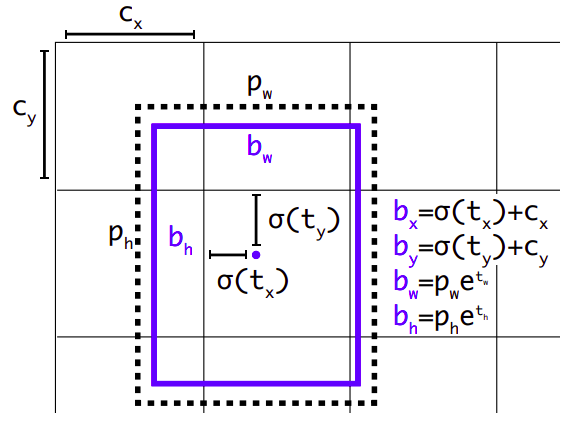

In [323]:
Image("local/imgs/yolo_predictions.png")


Typically, CNNs will 

- downsample image dimensions to $13x13$, or the number of cells defined, and will do a $(1,1)$ convolution in 2D with $n_a(5+C)$ channels, $n_a$ being the number of anchor boxes.

- make the same process in previous CNN layers (for instance when the activation map is $52x52$) or larger. So there is a set of prediction boxes

This will be ok to predict large object, but small ones get lost in CNN downsampling. To overcome this, different architectures use different techniques:

- YOLO3 make predictions in earlier CNN layers besides the last one.
- RetinaNet downsamples the image and then unsamples cativation maps, to integrate (sort of skipped connections) high level semantic information of late layers with spatial information from earlier layers.

See [this blog](https://medium.com/@jonathan_hui/what-do-we-learn-from-single-shot-object-detectors-ssd-yolo-fpn-focal-loss-3888677c5f4d) for further intuitions on this


## Loss function

Observe that we are doing **BOTH** regression (for boxes) **AND** classification (for object classes). A specific loss function must then be devised to take this into account.

See [this blog post](https://stats.stackexchange.com/questions/287486/yolo-loss-function-explanation) and [this blog post](https://stats.stackexchange.com/questions/373266/yolo-v3-loss-function) for detailed explanations.

## Non maximum suppression

Finally, as there might be many box predictions at different cells and resolutions, a decision must be taken for overlapping predictions. This is **Non maximum suppression**, and you can check [this blog](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) for a detailed explanation.